In [88]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [3]:
eagles = pd.read_csv('./data/eagles.csv')

In [4]:
eagles

,Unnamed: 0,y,n,P,A,V
0,1,17,24,L,A,L
1,2,29,29,L,A,S
2,3,17,27,L,I,L
3,4,20,20,L,I,S
4,5,1,12,S,A,L
5,6,15,16,S,A,S
6,7,0,28,S,I,L
7,8,1,4,S,I,S


- y number of sucessfull attempts
- n total number of attempts
- P large L or small S size of the pirate
- A adult A or infant I age of the pirate
- V same as P but for victim.

In [18]:
pss

{0: 'L', 1: 'S'}

In [19]:
pss = {v:k for k,v in enumerate(eagles['P'].unique())}
ass = {v:k for k,v in enumerate(eagles['A'].unique())}
vss = {v:k for k,v in enumerate(eagles['V'].unique())}


eagles["p_idx"] = eagles.P.apply(lambda x: pss[x])
eagles["a_idx"] = eagles.A.apply(lambda x: ass[x])
eagles["v_idx"] = eagles.V.apply(lambda x: vss[x])


In [35]:
with pm.Model() as m1:
    alpha = pm.Normal('alpha', 0, 1.5)
    beta_pirate = pm.Normal('beta_pirate', 0, 0.5)
    beta_age = pm.Normal('beta_age', 0, 0.5)
    beta_victim = pm.Normal('beta_victim', 0, 0.5)
    n = eagles.n
    p = pm.Deterministic('p', pm.math.invlogit(alpha + beta_pirate * eagles.p_idx + beta_age * eagles.a_idx + beta_victim * eagles.v_idx))    
    y = pm.Binomial('y', n, p=p, observed=eagles.y)

In [36]:
with m1:
    trace_m1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_pirate, beta_age, beta_victim]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

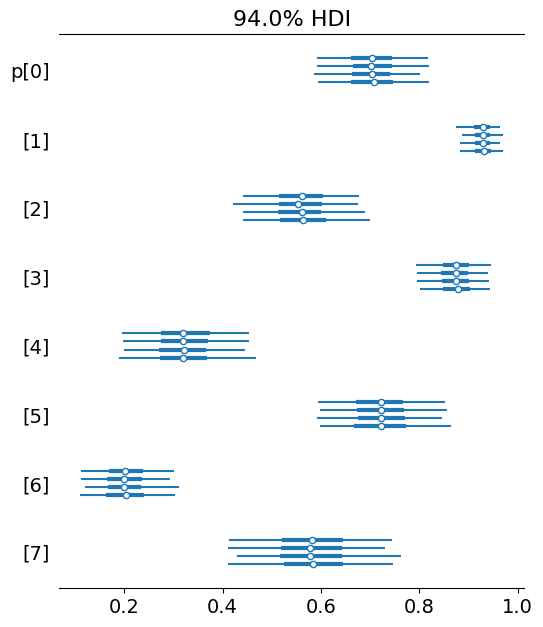

In [43]:
az.plot_forest(trace_m1.posterior['p'])

In [46]:
with m1:
    predictive_m1 = pm.sample_posterior_predictive(trace_m1)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

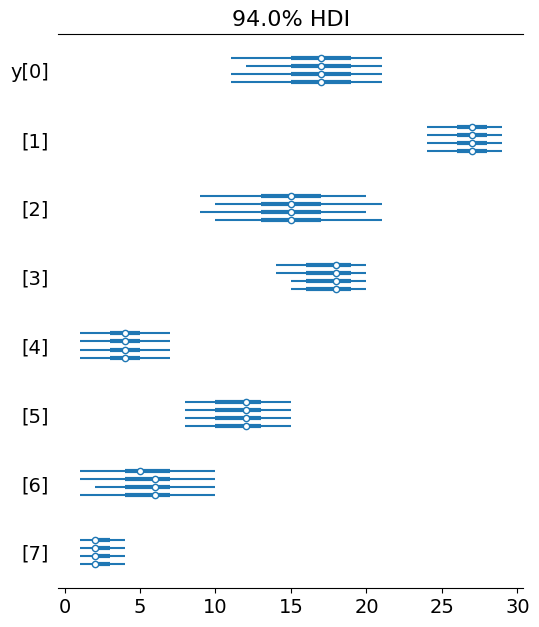

In [48]:
az.plot_forest(predictive_m1.posterior_predictive['y'])

In [51]:
def interaction_idx(p,a):
    return p + a*2


with pm.Model() as m2:
    alpha = pm.Normal('alpha', 0, 1.5)
    beta_pirate = pm.Normal('beta_pirate', 0, 0.5)
    beta_age = pm.Normal('beta_age', 0, 0.5)
    beta_victim = pm.Normal('beta_victim', 0, 0.5)
    beta_int = pm.Normal('beta_interaction', 0,0.5, shape=4)

    p = pm.Deterministic('p', pm.math.invlogit((alpha 
                                                + beta_pirate * eagles.p_idx 
                                                + beta_age * eagles.a_idx 
                                                + beta_victim * eagles.v_idx 
                                                + beta_int[interaction_idx(eagles.p_idx, eagles.a_idx)])))    
    y = pm.Binomial('y', n, p=p, observed=eagles.y)

In [52]:
with m2:
    trace_m2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_pirate, beta_age, beta_victim, beta_interaction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [55]:
az.waic(trace_m1), az.waic(trace_m2), az.loo(trace_m1), az.loo(trace_m2)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should c

(Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic   -29.38     5.86
 p_waic        8.27        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic   -25.35     3.59
 p_waic        7.81        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo   -30.22     6.17
 p_loo        9.11        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)        3   37.5%
  (0.5, 0.7]   (ok)          3   37.5%
    (0.7, 1]   (bad)         1   12.5%
    (1, Inf)   (very bad)    1   12.5%,
 Computed from 4000 poste

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

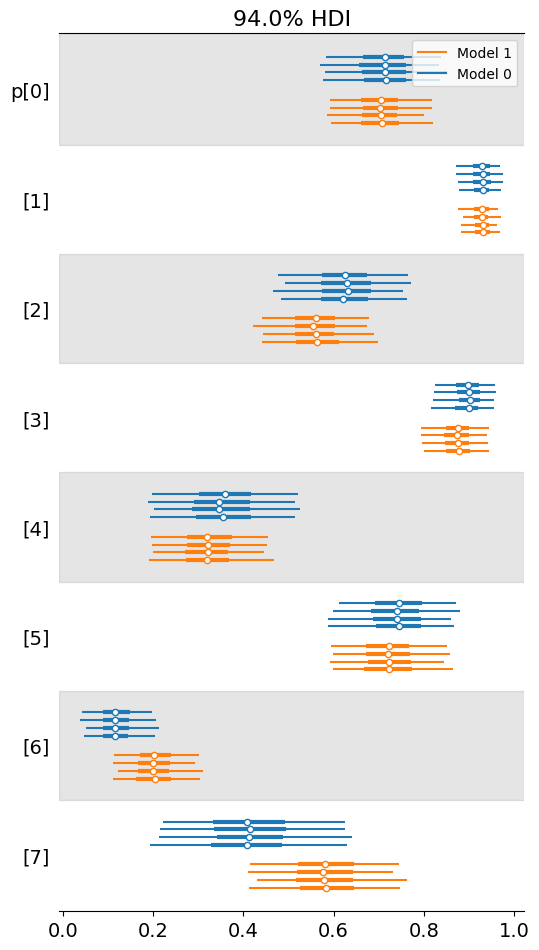

In [59]:
az.plot_forest([trace_m2.posterior['p'], trace_m1.posterior['p']])

In [60]:
k = az.loo(trace_m1, pointwise=True).pareto_k.values
k2 = az.loo(trace_m2, pointwise=True).pareto_k.values

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model

In [61]:
eagles['k']= k
eagles['k2'] = k2

In [64]:
eagles

,Unnamed: 0,y,n,P,A,V,p_idx,a_idx,v_idx,k,k2
0,1,17,24,L,A,L,0,0,0,0.410161,0.557690
1,2,29,29,L,A,S,0,0,1,0.540577,0.477577
2,3,17,27,L,I,L,0,1,0,0.388867,0.706841
3,4,20,20,L,I,S,0,1,1,0.622585,0.646607
4,5,1,12,S,A,L,1,0,0,0.607695,0.645681
5,6,15,16,S,A,S,1,0,1,0.771426,1.051348
6,7,0,28,S,I,L,1,1,0,1.045230,1.157723
7,8,1,4,S,I,S,1,1,1,0.167059,0.169421


So it seems that eagle number 6 tries a lot but doesn't have a single success. It's true that is the only small infant
atacker trying to reach a big victim, so probably that's the reason?
I'd add an interaction term on the size of the victim and the size of the pirate.
I guess that bigger wins. If they have the same size then the term shouldn't have much influence.

In [65]:
def interaction_idx(p,a):
    return p + a*2


with pm.Model() as m3:
    alpha = pm.Normal('alpha', 0, 1.5)
    beta_pirate = pm.Normal('beta_pirate', 0, 0.5)
    beta_age = pm.Normal('beta_age', 0, 0.5)
    beta_victim = pm.Normal('beta_victim', 0, 0.5)
    beta_int = pm.Normal('beta_interaction', 0,0.5, shape=4)
    
    p = pm.Deterministic('p', pm.math.invlogit((alpha 
                                                + beta_pirate * eagles.p_idx 
                                                + beta_age * eagles.a_idx 
                                                + beta_victim * eagles.v_idx 
                                                + beta_int[interaction_idx(eagles.p_idx, eagles.v_idx)])))    
    # note that the last term is interaction between sizes of eagles, not age as m2
    y = pm.Binomial('y', n, p=p, observed=eagles.y)

In [66]:
with m3:
    trace_m3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_pirate, beta_age, beta_victim, beta_interaction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

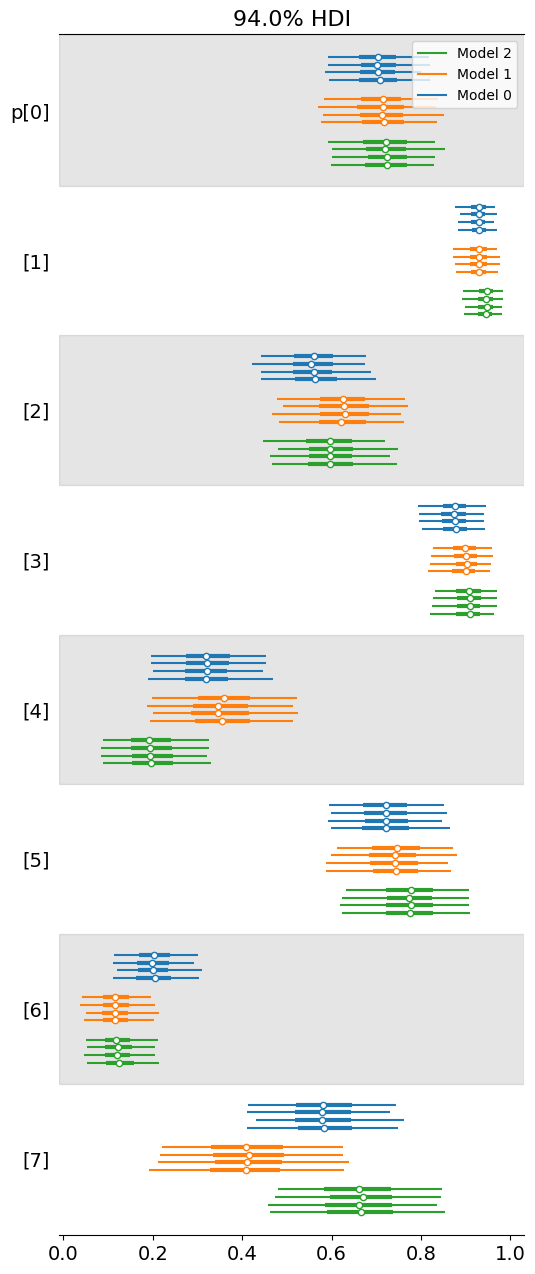

In [67]:
az.plot_forest([trace_m1.posterior['p'], trace_m2.posterior['p'], trace_m3.posterior['p']])

In [69]:
az.waic(trace_m3), az.loo(trace_m3)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


(Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic   -23.01     2.90
 p_waic        6.71        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo   -24.10     3.12
 p_loo        7.80        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)        2   25.0%
  (0.5, 0.7]   (ok)          3   37.5%
    (0.7, 1]   (bad)         3   37.5%
    (1, Inf)   (very bad)    0    0.0%)

In [70]:
k3 = az.loo(trace_m3, pointwise=True).pareto_k.values

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [71]:
eagles['k3']=k3

In [72]:
eagles

,Unnamed: 0,y,n,P,A,V,p_idx,a_idx,v_idx,k,k2,k3
0,1,17,24,L,A,L,0,0,0,0.410161,0.557690,0.339615
1,2,29,29,L,A,S,0,0,1,0.540577,0.477577,0.904131
2,3,17,27,L,I,L,0,1,0,0.388867,0.706841,0.865764
3,4,20,20,L,I,S,0,1,1,0.622585,0.646607,0.651575
4,5,1,12,S,A,L,1,0,0,0.607695,0.645681,0.407572
5,6,15,16,S,A,S,1,0,1,0.771426,1.051348,0.888366
6,7,0,28,S,I,L,1,1,0,1.045230,1.157723,0.694703
7,8,1,4,S,I,S,1,1,1,0.167059,0.169421,0.573066


So we improved the 6th one but still the fith lol I think is an oldy experienced but small nevertheless, let's get two interaction terms

In [74]:
def interaction_idx(p,a):
    return p + a*2


with pm.Model() as m4:
    alpha = pm.Normal('alpha', 0, 1.5)
    beta_pirate = pm.Normal('beta_pirate', 0, 0.5)
    beta_age = pm.Normal('beta_age', 0, 0.5)
    beta_victim = pm.Normal('beta_victim', 0, 0.5)
    beta_int = pm.Normal('beta_interaction', 0,0.5, shape=4)
    beta_int2 = pm.Normal('beta_interaction2', 0,0.5, shape=4)

    p = pm.Deterministic('p', pm.math.invlogit((alpha 
                                                + beta_pirate * eagles.p_idx 
                                                + beta_age * eagles.a_idx 
                                                + beta_victim * eagles.v_idx 
                                                + beta_int[interaction_idx(eagles.p_idx, eagles.v_idx)]
                                                + beta_int2[interaction_idx(eagles.p_idx, eagles.a_idx)])))    
    # note that the last term is interaction between sizes of eagles, not age as m2
    y = pm.Binomial('y', n, p=p, observed=eagles.y)

In [75]:
with m4:
    trace_m4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_pirate, beta_age, beta_victim, beta_interaction, beta_interaction2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [76]:
az.waic(trace_m4), az.loo(trace_m4)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


(Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic   -20.48     1.57
 p_waic        6.26        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 4000 posterior samples and 8 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo   -21.96     2.03
 p_loo        7.74        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)        1   12.5%
  (0.5, 0.7]   (ok)          4   50.0%
    (0.7, 1]   (bad)         3   37.5%
    (1, Inf)   (very bad)    0    0.0%)

In [77]:
k4 = az.loo(trace_m4, pointwise=True).pareto_k.values

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [78]:
eagles['k4']=k4

In [79]:
eagles

,Unnamed: 0,y,n,P,A,V,p_idx,a_idx,v_idx,k,k2,k3,k4
0,1,17,24,L,A,L,0,0,0,0.410161,0.557690,0.339615,0.552110
1,2,29,29,L,A,S,0,0,1,0.540577,0.477577,0.904131,0.627640
2,3,17,27,L,I,L,0,1,0,0.388867,0.706841,0.865764,0.606229
3,4,20,20,L,I,S,0,1,1,0.622585,0.646607,0.651575,0.518249
4,5,1,12,S,A,L,1,0,0,0.607695,0.645681,0.407572,0.774425
5,6,15,16,S,A,S,1,0,1,0.771426,1.051348,0.888366,0.929152
6,7,0,28,S,I,L,1,1,0,1.045230,1.157723,0.694703,0.777640
7,8,1,4,S,I,S,1,1,1,0.167059,0.169421,0.573066,0.437261


In [101]:
az.summary(trace_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.875,0.297,0.346,1.469,0.006,0.004,2684.0,2526.0,1.0
beta_pirate,-1.631,0.316,-2.198,-1.008,0.006,0.004,3264.0,2757.0,1.0
beta_age,-0.632,0.307,-1.181,-0.034,0.006,0.004,2737.0,2619.0,1.0
beta_victim,1.721,0.319,1.097,2.300,0.005,0.004,3810.0,3093.0,1.0
p[0],0.702,0.061,0.594,0.820,0.001,0.001,2684.0,2526.0,1.0
p[1],0.927,0.024,0.883,0.969,0.000,0.000,3800.0,3240.0,1.0
p[2],0.559,0.067,0.440,0.693,0.001,0.001,4385.0,3257.0,1.0
p[3],0.872,0.041,0.795,0.941,0.001,0.000,4131.0,3339.0,1.0
p[4],0.324,0.071,0.196,0.457,0.001,0.001,3386.0,3012.0,1.0
p[5],0.719,0.070,0.588,0.848,0.001,0.001,3694.0,3217.0,1.0


In [104]:
pss, ass, vss

({'L': 0, 'S': 1}, {'A': 0, 'I': 1}, {'L': 0, 'S': 1})

In [ ]:
So indeed the smaller the pirate, or younger, the worst it gets at hunting, likewise the smaller the victim, the worst
it gets at defending.

In [105]:
az.summary(trace_m2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.397,0.422,-0.430,1.158,0.009,0.006,2392.0,3084.0,1.0
beta_pirate,-1.006,0.399,-1.751,-0.255,0.007,0.005,3293.0,2905.0,1.0
beta_age,-0.443,0.384,-1.196,0.260,0.007,0.005,3305.0,3436.0,1.0
beta_victim,1.686,0.339,1.028,2.278,0.005,0.003,5114.0,3060.0,1.0
beta_interaction[0],0.524,0.402,-0.223,1.278,0.008,0.005,2867.0,3156.0,1.0
beta_interaction[1],-0.003,0.409,-0.763,0.769,0.007,0.006,3696.0,2801.0,1.0
beta_interaction[2],0.570,0.406,-0.147,1.357,0.007,0.005,3071.0,2744.0,1.0
beta_interaction[3],-1.000,0.420,-1.763,-0.190,0.006,0.005,4520.0,3169.0,1.0
p[0],0.710,0.071,0.577,0.841,0.001,0.001,6211.0,3309.0,1.0
p[1],0.926,0.028,0.870,0.971,0.000,0.000,6546.0,3509.0,1.0


In [ ]:
interactions: 3

    
0 -> p v = 0, large pirate vs large victim
1 -> p = 1 v=0 -> small pirate vs large victim -> 
2 -> p=0 v=1 -> large pirate vs small victim -> makes sense
3 -> p=1 v=1 -> both small



In [106]:
pss, ass, vss

({'L': 0, 'S': 1}, {'A': 0, 'I': 1}, {'L': 0, 'S': 1})

Ok, so depending on the sizes combinations probably affects the number of attempts. For example if both are small, and the pirate is small, is unlikely that they will atack. The S attacking L number is weird. Possibly
the small victim doesn't feed others? that's why it can't be attacked altogether, although the L one
does feed and can be (unsecsefully by a small) attacked?

## 11H3

In [81]:
salamanders = pd.read_csv('./data/salamanders.csv', sep=';')

In [82]:
salamanders

,SITE,SALAMAN,PCTCOVER,FORESTAGE
0,1,13,85,316
1,2,11,86,88
2,3,11,90,548
3,4,9,88,64
4,5,8,89,43
5,6,7,83,368
6,7,6,83,200
7,8,6,91,71
8,9,5,88,42
9,10,5,90,551


In [107]:
# 11H6

In [110]:
primates = pd.read_csv('./data/Primates301.csv', sep=';')

In [115]:
len(primates)

301

In [116]:
primates.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


log brain_size -> social_learning
log research_effort -> social_learning

in a poisson setting it think is easier to incorporate the fact that there are different measurements for each
 species if this was a binomial thing it wouldn't be easy. I wonder if I need to try a poisson model in the 11h2 or try a mixed poisson binomial model.



In [121]:
primates.species.nunique()

258

In [126]:
primates.groupby(['species', 'subspecies']).count().sort_values(by='name', ascending=False)

name  genus  spp_id  genus_id  \
species       subspecies                                        
angolensis    palliatus            1      1       1         1   
nemestrina    siberu               1      1       1         1   
griseus       meridionalis         1      1       1         1   
              occidentalis         1      1       1         1   
lemurinus     griseimembra         1      1       1         1   
macaco        flavifrons           1      1       1         1   
              macaco               1      1       1         1   
nemestrina    leonina              1      1       1         1   
pygerythrus   cynosurus            1      1       1         1   
azarai        boliviensis          1      1       1         1   
sapiens       neanderthalensis     1      1       1         1   
torquatus     atys                 1      1       1         1   
troglodytes   schweinfurthii       1      1       1         1   
              troglodytes          1      1       1         1   
              vellerosus           1      1       1         1   
              verus                1      1       1         1   
griseus       griseus              1      1       1         1   
              alaotrensis          1      1       1         1   
gorilla       graueri              1      1       1         1   
              gorilla              1      1       1         1   
fuscicollis   melanoleucus         1      1       1         1   
furcifer      pallescens           1      1       1         1   
fulvus        sanfordi             1      1       1         1   
              rufus                1      1       1         1   
              mayottensis          1      1       1         1   
              fulvus               1      1       1         1   
              collaris             1      1       1         1   
              albocollaris         1      1       1         1   
              albifrons            1      1       1         1   
erythrogaster erythrogaster        1      1       1         1   
cephus        ngottoensis          1      1       1         1   
              cephus               1      1       1         1   
campbelli     lowei                1      1       1         1   
variegata     variegata            1      1       1         1   

                                social_learning  research_effort  brain  body  \
species       subspecies                                                        
angolensis    palliatus                       0                0      0     0   
nemestrina    siberu                          0                0      0     0   
griseus       meridionalis                    0                0      0     0   
              occidentalis                    0                0      1     0   
lemurinus     griseimembra                    0                0      0     0   
macaco        flavifrons                      0                0      0     0   
              macaco                          1                1      1     1   
nemestrina    leonina                         0                0      0     0   
pygerythrus   cynosurus                       0                0      0     0   
azarai        boliviensis                     0                0      0     0   
sapiens       neanderthalensis                0                0      0     0   
torquatus     atys                            0                0      1     1   
troglodytes   schweinfurthii                  0                0      1     1   
              troglodytes                     1                1      1     1   
              vellerosus                      0                0      0     0   
              verus                           0                0      1     1   
griseus       griseus                         0                0      0     0   
              alaotrensis                     0                0      1     1   
gorilla       graueri                         0                0      0

In [156]:
primates_2=primates[~primates.brain.isna() & ~primates.research_effort.isna()].copy()

So there's repetition of species but not (species, subpspecies)

In [177]:
primates_2['log_brain_size'] = np.log(primates_2.brain)
primates_2['log_research_effort'] = np.log(primates_2.research_effort)

with pm.Model() as m1:
    log_brain_size = pm.MutableData('log_brain_size', primates_2.log_brain_size)
    alpha = pm.Normal('alpha',0, 0.2)
    beta_brain= pm.Normal('beta_brain', 0, 0.2)
    l = pm.Deterministic('l', pm.math.exp(alpha + beta_brain * log_brain_size))
    learning = pm.Poisson('learning', l, observed=primates_2.social_learning)
    
with pm.Model() as m2:
    log_brain_size = pm.MutableData('log_brain_size', primates_2.log_brain_size)
    log_research_effort = pm.MutableData('log_research_effort', primates_2.log_brain_size)
        
    alpha = pm.Normal('alpha', 0.2)
    beta_brain= pm.Normal('beta_brain', 0, 0.2)
    beta_research_effort= pm.Normal('beta_research_effort', 0, 0.2)
    l = pm.Deterministic('l', pm.math.exp(alpha + beta_brain * log_brain_size + beta_research_effort * log_research_effort))
    learning = pm.Poisson('learning', l, observed=primates_2.social_learning)

I think that probably the bigger the brain size the most interesting behaviors, the more complex anymal thus more reserach effort.
So brain is a common cause to both social learning and research effort, and also research effort is a cause
for sensoring social learning, so we need to stratify by research effort to calculate direct effect
of brain on social learning

In [178]:
with m1: 
    prior_trace_m1= pm.sample_prior_predictive()
    posterior_trace_m1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_brain]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.6862, but should be close to 0.8. Try to increase the number of tuning steps.


In [179]:
with m2: 
    prior_trace_m2= pm.sample_prior_predictive()
    posterior_trace_m2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_brain, beta_research_effort]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


<AxesSubplot:>

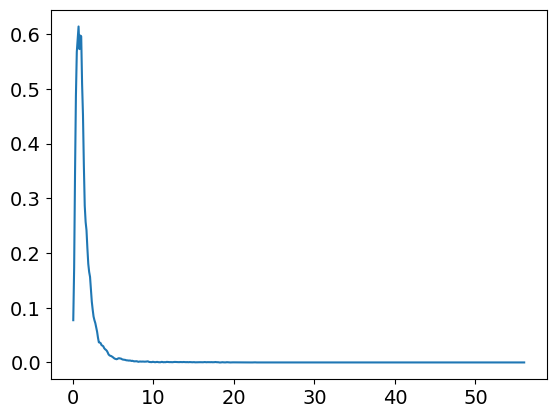

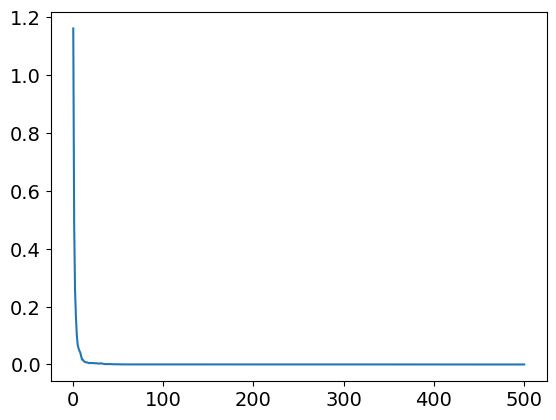

In [180]:
az.plot_dist(prior_trace_m1.prior['l'])
plt.figure()
az.plot_dist(prior_trace_m2.prior['l'])

These priors look to wide, in a real case I'd use domain knowledge to understand plausibility

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

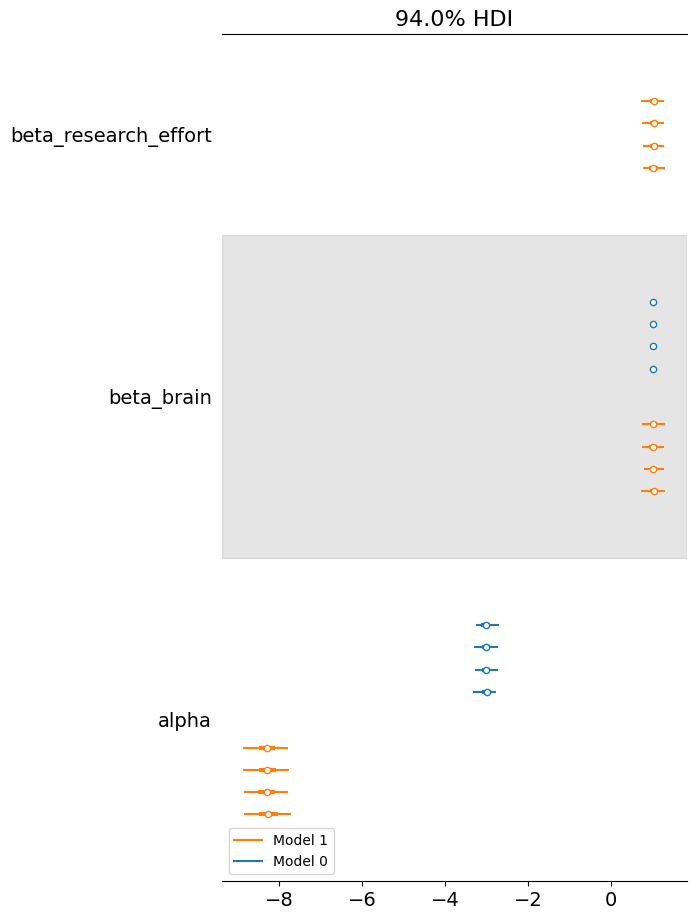

In [181]:
az.plot_forest([posterior_trace_m1, posterior_trace_m2], var_names=['beta_research_effort', 'beta_brain', 'alpha'])

In [186]:
az.waic(posterior_trace_m1), az.waic(posterior_trace_m2)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


(Computed from 4000 posterior samples and 150 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic  -997.71   440.84
 p_waic      185.80        -
 
 There has been a warning during the calculation. Please check the results.,
 Computed from 4000 posterior samples and 150 observations log-likelihood matrix.
 
           Estimate       SE
 elpd_waic  -728.94   255.15
 p_waic      147.53        -
 
 There has been a warning during the calculation. Please check the results.)

In [185]:
az.loo(posterior_trace_m1), az.loo(posterior_trace_m2)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model

(Computed from 4000 posterior samples and 150 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo  -911.51   358.69
 p_loo       99.60        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      146   97.3%
  (0.5, 0.7]   (ok)          2    1.3%
    (0.7, 1]   (bad)         0    0.0%
    (1, Inf)   (very bad)    2    1.3%,
 Computed from 4000 posterior samples and 150 observations log-likelihood matrix.
 
          Estimate       SE
 elpd_loo  -679.52   215.14
 p_loo       98.10        -
 
 There has been a warning during the calculation. Please check the results.
 ------
 
 Pareto k diagnostic values:
                          Count   Pct.
 (-Inf, 0.5]   (good)      145   96.7%
  (0.5, 0.7]   (ok)          0    0.0%
    (0.7, 1]   (bad)         3    2.0%
    (1, Inf)   (very bad)    2    1.3%)

We have high leverage points in both cases.

In [187]:
with m1:
    pp_m1 = pm.sample_posterior_predictive(posterior_trace_m1)

with m2:
    pp_m2 = pm.sample_posterior_predictive(posterior_trace_m2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


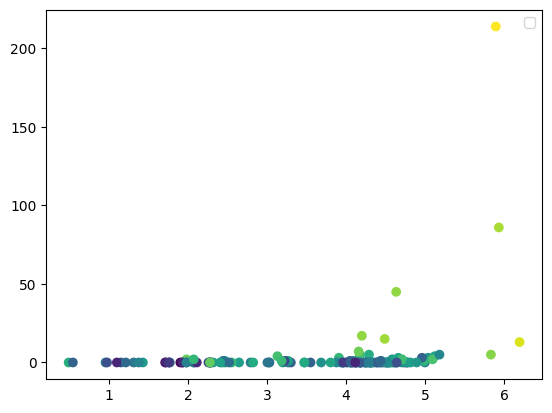

In [208]:
plt.figure()
plt.scatter(primates_2['log_brain_size'], primates_2['social_learning'], c=primates_2['log_research_effort'])
plt.legend()
plt.scatter()
az.plot_forest([pp_m1.posterior_predictive['learning'],
                pp_m2.posterior_predictive['learning']])

In [210]:
k_m1 = az.loo(posterior_trace_m1, pointwise=True).pareto_k.values
k_m2 = az.loo(posterior_trace_m2, pointwise=True).pareto_k.values


/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model

In [211]:
primates_2['k_m1']=k_m1
primates_2['k_m2']=k_m2

In [214]:
focus = primates_2[['social_learning', 'log_research_effort', 'log_brain_size', 'k_m1', 'k_m2']]

In [216]:
focus[focus.k_m1 > 0.7]

,social_learning,log_research_effort,log_brain_size,k_m1,k_m2
224,214.0,6.626718,5.894541,4.908038,4.523726
247,86.0,5.771441,5.933253,1.669935,0.992473


<AxesSubplot:>

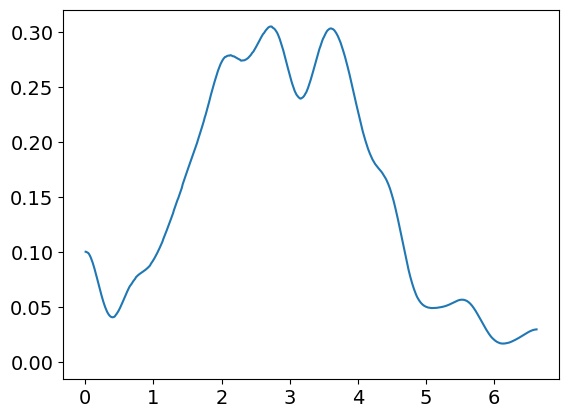

In [217]:
az.plot_kde(primates_2.log_research_effort)

<AxesSubplot:>

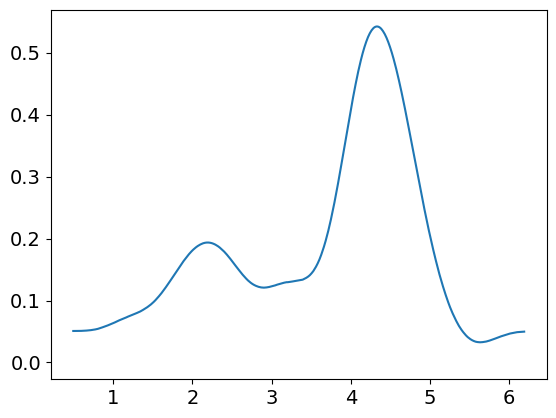

In [218]:
az.plot_kde(primates_2.log_brain_size)

Maybe what we are seeing here is an interaction effect between brain size and research effort. If a primate
has a ~decent big size and is of interest, then we are going to see insane lots of social learning. This could be the case
if there are other reasons for research intereset not only tied to brain size.

In [219]:
with pm.Model() as m3:
    log_brain_size = pm.MutableData('log_brain_size', primates_2.log_brain_size)
    log_research_effort = pm.MutableData('log_research_effort', primates_2.log_brain_size)
        
    alpha = pm.Normal('alpha', 0.2)
    beta_brain= pm.Normal('beta_brain', 0, 0.2)
    beta_research_effort= pm.Normal('beta_research_effort', 0, 0.2)
    beta_interaction= pm.Normal('beta_interaction', 0, 0.2)

    l = pm.Deterministic('l', pm.math.exp((alpha 
                                           + beta_brain * log_brain_size 
                                           + beta_research_effort * log_research_effort
                                           + beta_interaction * log_research_effort * log_brain_size)
                                         ))
    learning = pm.Poisson('learning', l, observed=primates_2.social_learning)

In [220]:
with m3: 
    prior_trace_m3= pm.sample_prior_predictive()
    posterior_trace_m3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_brain, beta_research_effort, beta_interaction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.


In [221]:
az.loo(posterior_trace_m3)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -662.99   217.55
p_loo       97.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      144   96.0%
 (0.5, 0.7]   (ok)          2    1.3%
   (0.7, 1]   (bad)         1    0.7%
   (1, Inf)   (very bad)    3    2.0%

In [224]:
az.compare({'m1':posterior_trace_m1,
            'm2':posterior_trace_m2,
            'm3':posterior_trace_m3})

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,-662.992290,97.136766,0.000000,8.917741e-01,217.550944,0.000000,True,log
m2,1,-679.515672,98.102798,16.523382,8.107822e-11,215.143421,41.078565,True,log
m1,2,-911.507900,99.598414,248.515609,1.082259e-01,358.686298,216.873029,True,log


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

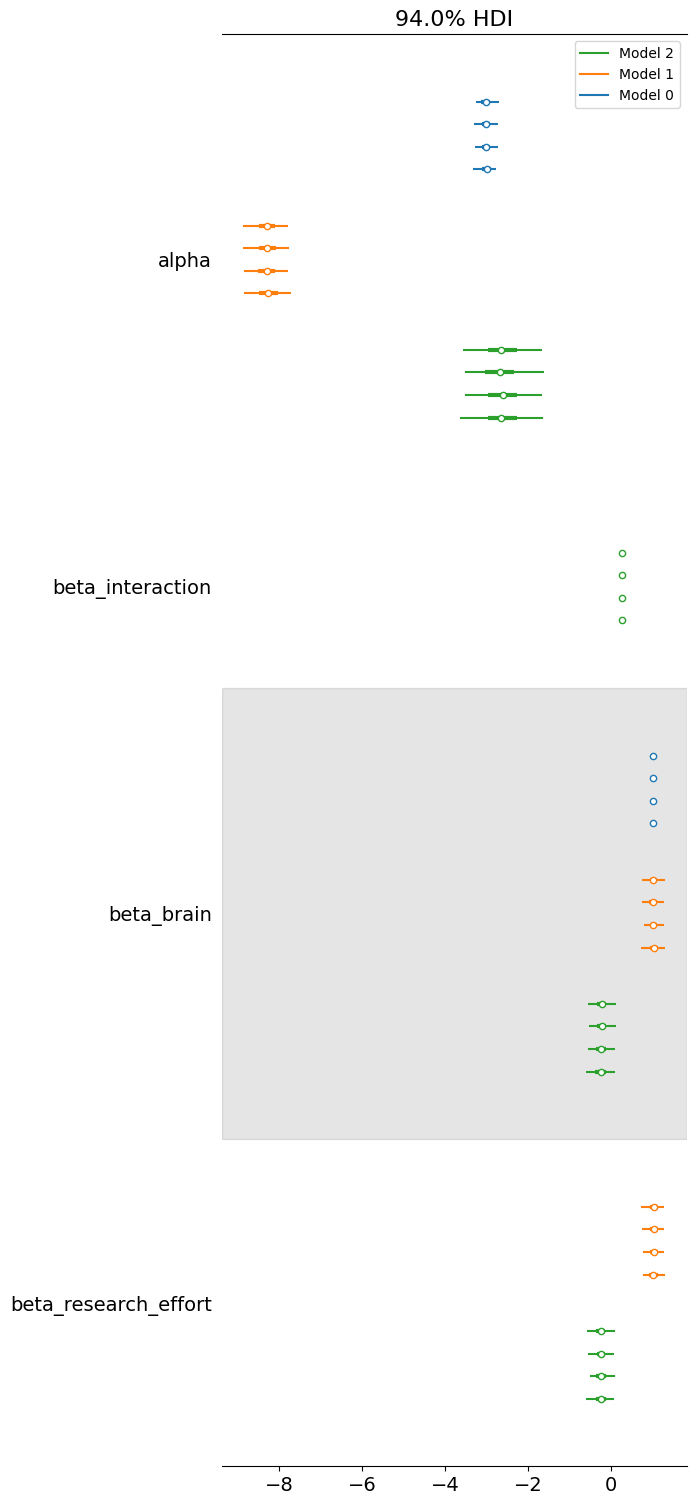

In [227]:
az.plot_forest([posterior_trace_m1, posterior_trace_m2, posterior_trace_m3], var_names=['alpha', 'beta_interaction', 'beta_brain', 'beta_research_effort'])

What in think is going on here is that social_learning is actually 'measured social learning' in the sense that
a species that has instrinsic a lot of social learning, but doesn't have research effort, it won't be measured.
This in turn means that brain only affects 'measured_social_learning' if the research effort is high

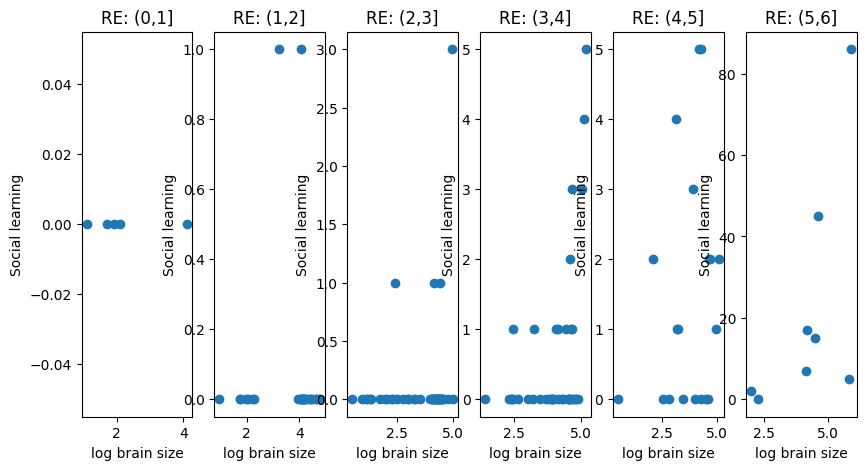

In [243]:
segments = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6)]
fig, ax = plt.subplots(1,6, figsize=(10,5))
for left, right in segments:
    focus_2=primates_2[(primates_2.log_research_effort <= right) & (primates_2.log_research_effort > left)]
    ax[left].scatter(focus_2.log_brain_size, focus_2.social_learning)
    ax[left].set_title(f"RE: ({left},{right}]")
    ax[left].set_xlabel('log brain size')
    ax[left].set_ylabel('Social learning')

Indeed, with increased research effort, we get more measured social learning. In the low segemnts of research effort we have lots and lots of cases of big brain size but low social learning.

Here it's difficult to really say something since I don't know the unit of 'research effort'. If it was trip for measurement, well, that would be something we can say something about 'success rate' but its a continous measurement (money invested?).

In [245]:
focus

,social_learning,log_research_effort,log_brain_size,k_m1,k_m2
0,0.0,1.791759,4.060788,0.011895,-0.099389
2,0.0,2.708050,3.967268,0.003444,-0.095502
3,0.0,3.806662,3.963286,0.010439,-0.093455
4,0.0,3.610918,3.945458,0.007888,-0.081755
5,3.0,4.369448,3.909620,0.068179,-0.046806
...,...,...,...,...,...
294,0.0,1.791759,4.129068,0.020135,-0.095529
295,0.0,2.772589,4.288265,-0.030329,-0.086255
296,0.0,1.609438,4.640923,-0.043638,-0.107658
298,0.0,0.693147,4.115617,0.031477,-0.097761


In [246]:
focus[focus.k_m1 > 0.7]

,social_learning,log_research_effort,log_brain_size,k_m1,k_m2
224,214.0,6.626718,5.894541,4.908038,4.523726
247,86.0,5.771441,5.933253,1.669935,0.992473


In [248]:
primates_2[primates_2.k_m1 > 0.7]

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment,log_brain_size,log_research_effort,k_m1,k_m2
224,Pan_troglodytes_troglodytes,Pan,troglodytes,troglodytes,225,48,214.0,755.0,363.05,52750.0,50.0,231.49,1260.81,720.0,3897.96,1492.30,5.894541,6.626718,4.908038,4.523726
247,Pongo_pygmaeus,Pongo,pygmaeus,NaN,248,54,86.0,321.0,377.38,58542.0,1.0,259.42,1088.80,720.0,3318.62,1348.22,5.933253,5.771441,1.669935,0.992473


(array([76., 27., 14., 10.,  8.,  3.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. , 51.4, 59.8, 68.2, 76.6, 85. ]),
 <BarContainer object of 10 artists>)

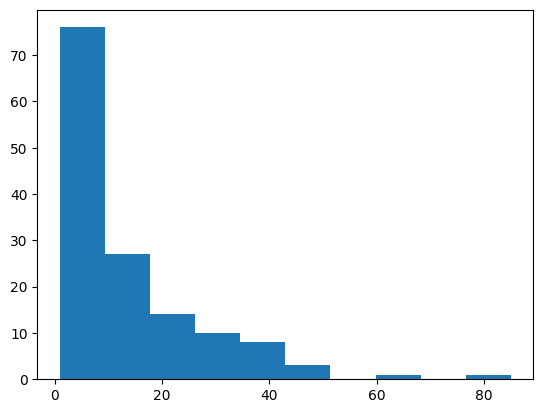

In [250]:
plt.hist(primates_2.group_size)

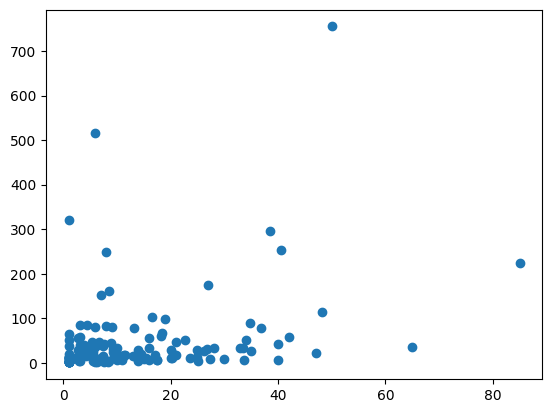

In [251]:
plt.scatter(primates_2.group_size, primates_2.research_effort)

So possibly we have things such as 'easyness to find' -> aka group_size_/research_effort. We have there
some cases in which you have to invest a lot of effort to increase group size, some other cases in which
with less effort you can increase the group size, and some cases in which they don't invest, thus the group size is small.
I gueess that in the chapter of measurement error we could incorporate something here. Like the bigger the group_size
the less the uncertainty?